In [60]:
import numpy as np
import h5py
import random
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns


# Data Preprocessing

In [40]:
file_path = './data/ROAD_dataset.h5'

In [44]:
def load_and_sample_data(file_path, sample_size):
    """
    Load HDF5 data, randomly sample from each category, include all 4 dimensions of spectrogram data 
    and frequency band, label the data, and return a combined DataFrame.
    
    Args:
        file_path (str): Path to the HDF5 file.
        sample_size (int): Number of samples to select from each category.
    
    Returns:
        pd.DataFrame: Combined DataFrame with sampled data, labels, and all dimensions included.
    """
    with h5py.File(file_path, "r") as file:
        combined_data = []
        
        # Process Normal data
        normal_data = file["train_data"]["data"][:]  # Shape (3687, 256, 256, 4)
        normal_band = file["train_data"]["frequency_band"][:]  # Shape (3687, 256, 256, 1)
        normal_labels = file["train_data"]["labels"][:]

        # Find indices where labels are empty ('')
        normal_indices = np.where(normal_labels == b'')[0]

        # Randomly select samples
        selected_normal_indices = np.random.choice(normal_indices, sample_size, replace=False)
        sampled_normal_data = normal_data[selected_normal_indices]
        sampled_normal_band = normal_band[selected_normal_indices]
        sampled_normal_labels = np.array(["Normal"] * sample_size)

        # Combine spectrogram and frequency band along the last dimension
        combined_normal_data = np.concatenate((sampled_normal_data, sampled_normal_band), axis=-1)

        # Append to combined data
        combined_data.append(
            pd.DataFrame({
                "data": list(combined_normal_data),
                "label": sampled_normal_labels
            })
        )
        
        # Process Anomaly data
        for group in file["anomaly_data"]:
            group_data = file[f"anomaly_data/{group}/data"][:]  # Shape (n, 256, 256, 4)
            group_band = file[f"anomaly_data/{group}/frequency_band"][:]  # Shape (n, 256, 256, 1)
            group_labels = file[f"anomaly_data/{group}/labels"][:]
            group_labels = np.array([label.decode('utf-8') for label in group_labels])

            # Randomly select samples
            selected_indices = np.random.choice(len(group_data), sample_size, replace=False)
            sampled_group_data = group_data[selected_indices]
            sampled_group_band = group_band[selected_indices]
            sampled_group_labels = group_labels[selected_indices]

            # Combine spectrogram and frequency band along the last dimension
            combined_group_data = np.concatenate((sampled_group_data, sampled_group_band), axis=-1)

            # Append to combined data
            combined_data.append(
                pd.DataFrame({
                    "data": list(combined_group_data),
                    "label": sampled_group_labels
                })
            )

        # Concatenate all sampled data
        final_df = pd.concat(combined_data, ignore_index=True)
        
    return final_df




In [45]:
sample_size = 56
final_data = load_and_sample_data(file_path, sample_size)

In [46]:
final_data.head()

,data,label
0,"[[[100194870.0, 2114462.2, 2114462.2, 93913730...",Normal
1,"[[[130215630.0, 2777670.5, 2777670.5, 13002362...",Normal
2,"[[[167604660.0, 2065017.6, 2065017.6, 17802525...",Normal
3,"[[[60425330.0, 1773702.9, 1773702.9, 56035732....",Normal
4,"[[[59763936.0, 2384297.0, 2384297.0, 56522344....",Normal


In [51]:
x = np.stack(final_data['data'].values)
x = x.reshape(x.shape[0], -1)

In [54]:
y = final_data['label'].values

In [58]:
X_train, X_temp, y_train, y_temp = train_test_split(x, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [59]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

Validation Metrics:
                                                           precision    recall  f1-score   support

                                                   Normal       0.19      0.50      0.27         6
                                    first_order_data_loss       1.00      1.00      1.00        12
                                   first_order_high_noise       0.80      0.44      0.57         9
                                           galactic_plane       0.67      0.40      0.50         5
                    galactic_plane-first_order_high_noise       0.00      0.00      0.00         1
                       galactic_plane-source_in_sidelobes       0.18      0.50      0.27         4
galactic_plane-source_in_sidelobes-first_order_high_noise       0.00      0.00      0.00         1
galactic_plane-source_in_sidelobes-third_order_high_noise       0.00      0.00      0.00         1
                                                lightning       1.00      0.44      0.62

/Users/anniepham/Desktop/brians/Turion Project/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/anniepham/Desktop/brians/Turion Project/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/anniepham/Desktop/brians/Turion Project/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _w

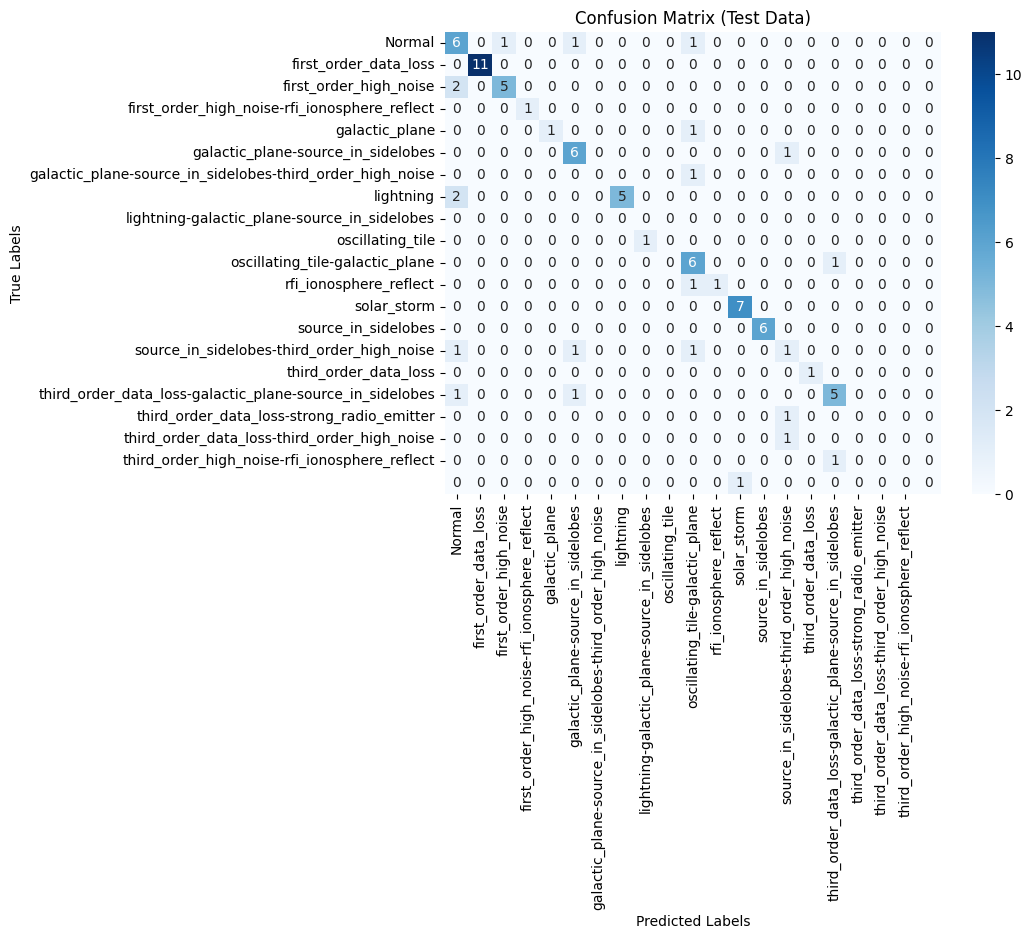

In [61]:
# Step 1: Predict on Validation and Test Data
y_val_pred = rf_model.predict(X_val)
y_test_pred = rf_model.predict(X_test)

# Step 2: Evaluate Metrics for Validation Data
print("Validation Metrics:")
print(classification_report(y_val, y_val_pred))  # Precision, Recall, F1-score
print(f"Validation Accuracy: {accuracy_score(y_val, y_val_pred):.2f}")

# Step 3: Evaluate Metrics for Test Data
print("\nTest Metrics:")
print(classification_report(y_test, y_test_pred))  # Precision, Recall, F1-score
print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred):.2f}")

# Step 4: Confusion Matrix for Test Data
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Visualize the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title("Confusion Matrix (Test Data)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()
